# Practical 4: Text Clustering and Topic Modeling
#### Ayoub Bagheri
<img src="img/uu_logo.png" alt="logo" align="right" title="UU" width="50" height="20" />

#### Applied Text Mining - Utrecht Summer School

In this practical, we are going to apply different clustering algorithms and a topic modeling approach on sport news articles and cluster them into different groups.

Today we will use the following libraries. Take care to have them installed!

In [1]:
from sklearn.datasets import load_files
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from sklearn import metrics

from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

# for reproducibility
random_state = 321

### Let's get started!

1\. **Here we are going to use a another set of the BBC news articles, the BBC Sport dataset. This dataset was provided for use as benchmarks for machine learning research. The BBC Sport dataset consists of 737 documents from the BBC Sport website corresponding to sports news articles from 2004-2005 in five topical areas: athletics, cricket, football, rugby, tennis. Upload the `bbcsport-fulltext.zip` file and extract it using the code below. Convert the resulting object to a dataframe.**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving bbcsport-fulltext.zip to bbcsport-fulltext.zip


In [3]:
%%capture
!unzip /content/bbcsport-fulltext.zip

In [4]:
data = load_files('/content/bbcsport-fulltext/bbcsport', encoding="utf-8", decode_error="replace", random_state=random_state)
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df.head()

,text,label
0,"Scotland v Italy (Sat)\n\nMurrayfield, Edinbur...",3
1,Wales silent on Grand Slam talk\n\nRhys Willia...,3
2,Arsenal 1-1 Sheff Utd\n\nAndy Gray's 90th-minu...,2
3,Cole refuses to blame van Persie\n\nAshley Col...,2
4,Van Nistelrooy hungry for return\n\nManchester...,2


In [5]:
labels, counts = np.unique(df['label'], return_counts=True)
print(dict(zip(data.target_names, counts)))

{'athletics': 101, 'cricket': 124, 'football': 265, 'rugby': 147, 'tennis': 100}


2\. **For text clustering and topic modeling, we will ignore the outcome variable (labels) but we will use them while evaluating models. Create a copied dataframe removing the outcome variable.**

In [6]:
bbcsport_text = pd.DataFrame(df['text'])
bbcsport_text.head()

,text
0,"Scotland v Italy (Sat)\n\nMurrayfield, Edinbur..."
1,Wales silent on Grand Slam talk\n\nRhys Willia...
2,Arsenal 1-1 Sheff Utd\n\nAndy Gray's 90th-minu...
3,Cole refuses to blame van Persie\n\nAshley Col...
4,Van Nistelrooy hungry for return\n\nManchester...


3\. **Apply the following pre-processing steps and convert the data to a document-term matrix with term frequencies:**
- convert to lowercase
- remove stopwords
- remove numbers
- extract uni- and bi-grams
- remove terms that occur in less than 2 documents
- remove one-letter terms, e.g.'a', or 's'

In [7]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   lowercase=True,
                                   min_df=2,
                                   ngram_range=(1,2),
                                   token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b')
tfidf_vectorizer.fit(df.text.values)
tfidf_matrix = tfidf_vectorizer.transform(df.text.values)
tfidf_matrix.shape

(737, 21604)

In [ ]:
# You can check the vocabulary of your vectorizer with the following line
# tfidf_vectorizer.vocabulary_

### K-Means clustering

4\. **Use the MiniBatchKMeans function from the sklearn package, and a K-Means clustering algorithm with 5 clusters.**

In [8]:
n_clusters = 5
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state, n_init = 3)
cls.fit(tfidf_matrix)

MiniBatchKMeans(n_clusters=5, n_init=3, random_state=321)

5\. **What are the top terms in each cluster?**

In [9]:
print("Top terms per cluster:")

order_centroids = cls.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s/' % terms[ind], end='')
    print()
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

Top terms per cluster:
Cluster 0: cricket/ test/ pakistan/ day/ series/ india/ england/ australia/ south/ south africa/
Cluster 1: chelsea/ club/ arsenal/ united/ said/ league/ liverpool/ cup/ game/ manager/
Cluster 2: olympic/ race/ indoor/ world/ champion/ athens/ holmes/ european/ athletics/ year/
Cluster 3: seed/ open/ federer/ set/ hewitt/ australian/ roddick/ henman/ final/ win/
Cluster 4: england/ wales/ ireland/ rugby/ nations/ robinson/ france/ half/ scotland/ lions/


Based on these 10 top terms we can manually label our clustering output as:
- cluster 0: cricket
- cluster 1: tennis
- cluster 2: football
- cluster 3: athletics
- cluster 4: rugby

6\. **Visualize the output of the K-Means clustering: first apply a PCA method to transform the high-dimensional feature space into 2 dimensions, and then plot the points using a scatter plot.**

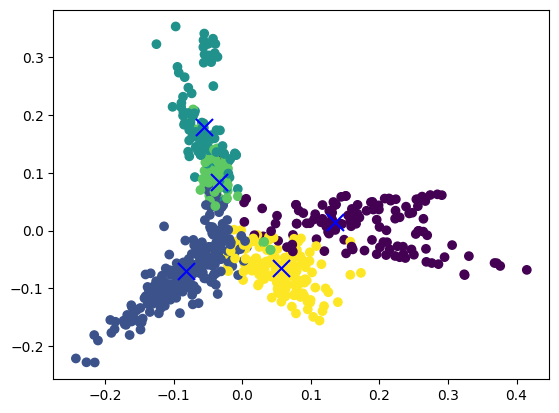

In [10]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(tfidf_matrix))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

7\. **Evaluate the quality of the K-Means clustering with the `sklearn` metrics for clustering: `homogeneity_score`, `completeness_score`, `v_measure_score`, `adjusted_rand_score`, `silhouette_score`.**

Evaluation for unsupervised learning algorithms is a bit difficult and requires human judgement but there are some metrics which you might use. There are two kinds of metrics you can use depending on whether or not you have the labels.

If you have a labelled dataset you can use metrics that give you an idea of how good your clustering model is. For this purpose you can use the `sklearn.metrics` module, for example `homogeneity_score` is one of the possible metrics. As per the documentation, the score ranges between 0 and 1 where 1 stands for perfectly homogeneous labeling.

If you do not have labels for your dataset, then you can still evaluate your clustering model with some metrics. One of them is the `silhouette_score`. From the `sklearn`'s documentation: The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a,b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [11]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(data.target, cls.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(data.target, cls.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(data.target, cls.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(data.target, cls.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tfidf_matrix, cls.labels_, sample_size=1000))

Homogeneity: 0.840
Completeness: 0.845
V-measure: 0.842
Adjusted Rand-Index: 0.867
Silhouette Coefficient: 0.017


8\. **Apply the K-Means clustering method on a range of 3 to 7 clusters, and calculate the squared loss obtained in each clustering. Apply the Elbow method to find the optimal k. (Tip: use the `cls.inertia_` for the squared loss)**

In [12]:
num_clus = [x for x in range(3, 7)]
squared_errors = []
for cluster in num_clus:
    cls = MiniBatchKMeans(n_clusters=cluster, random_state=random_state, n_init = 3)
    cls.fit(tfidf_matrix) # Train Clusters
    squared_errors.append(cls.inertia_) # Appending the squared loss obtained in the list

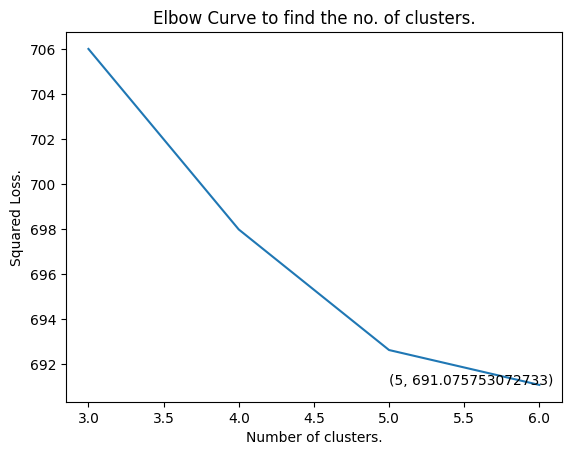

The optimal number of clusters obtained is -  5
The loss for optimal cluster is -  691.075753072733


In [13]:
# https://www.kaggle.com/karthik3890/text-clustering
# Choosing the best cluster using Elbow Method.
# source credit,few parts of min squred loss info is taken from different parts of the stakoverflow answers.
# this is used to understand to find the optimal clusters in differen way rather than used in BOW, TFIDF

num_clus = [x for x in range(3, 7)]
squared_errors = []
for cluster in num_clus:
    cls = MiniBatchKMeans(n_clusters=cluster, random_state=random_state, n_init = 3)
    cls.fit(tfidf_matrix) # Train Clusters
    squared_errors.append(cls.inertia_) # Appending the squared loss obtained in the list

optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss.
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve to find the no. of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

9\. **Use the following two news articles as your test data, and predict cluster labels for your new dataset with the best value for K and the K-Means algorithm.**

In [14]:
documents = ['Frank de Boer out as Oranje manager after early Euro 2020 exit Dutch men’s football team coach.',
             'The time has come for Nadal to be selective in the events that he should and should not play. This is where he can start the difficulty. After a rigorous participation of the clay season, Rafael Nadal definitely wants to conserve his energies for as long as possible.']

In [15]:
n_clusters = 5
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state, n_init = 3)
cls.fit(tfidf_matrix)

MiniBatchKMeans(n_clusters=5, n_init=3, random_state=321)

In [16]:
tfidf_test = tfidf_vectorizer.transform(documents)
tfidf_test.shape

(2, 21604)

In [17]:
print(cls.predict(tfidf_test))

[1 1]


### Hierarchical clustering

10\. **Hierarchical clustering is a type of unsupervised machine learning algorithm used to cluster unlabeled data points. Similar to the K-Means clustering, hierarchical clustering groups the data points with similar characteristics together. Apply a hierarchical clustering with the ward linkage on the BBC Sport dataset. Fit the model with 5 clusters and check the predicted labels.**

In [18]:
cls2 = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
cls2 = cls2.fit(tfidf_matrix.toarray())

In [19]:
cls2.labels_

array([4, 4, 2, 2, 2, 4, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 4, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 4, 1, 0, 2, 2, 2, 0, 2,
       2, 1, 2, 2, 4, 0, 1, 0, 4, 2, 2, 1, 2, 1, 0, 2, 4, 0, 0, 0, 1, 2,
       2, 0, 0, 2, 1, 4, 2, 2, 0, 1, 2, 2, 0, 4, 4, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 0, 0, 1, 0, 2, 3, 4, 0, 1, 4, 2, 0, 0, 4, 2, 2, 4, 4, 2, 2,
       1, 0, 4, 4, 2, 0, 0, 0, 2, 4, 1, 2, 2, 1, 4, 2, 2, 2, 0, 0, 1, 1,
       4, 4, 2, 1, 2, 2, 0, 0, 2, 3, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0,
       4, 2, 1, 2, 4, 2, 2, 2, 2, 4, 2, 4, 0, 0, 4, 2, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 0, 4, 0, 4, 1, 1, 0, 0, 4, 2, 2, 1, 1, 4, 2, 1, 2,
       2, 0, 4, 2, 0, 2, 4, 4, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 4, 3, 2, 2,
       0, 4, 1, 1, 1, 2, 2, 1, 1, 4, 1, 4, 2, 1, 2, 2, 2, 1, 4, 1, 2, 2,
       2, 2, 2, 4, 2, 0, 1, 4, 4, 1, 0, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 0, 2, 4, 2, 2, 2, 1, 4, 1, 0, 2, 4, 0, 2, 1, 0,
       0, 0, 4, 2, 2, 0, 2, 0, 0, 2, 4, 2, 0, 0, 4,

11\. **Plot a dendrogram for your hierarchical clustering model using the function below. To do this, you need to fit the model again without assigning the number of clusters.**

In [20]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

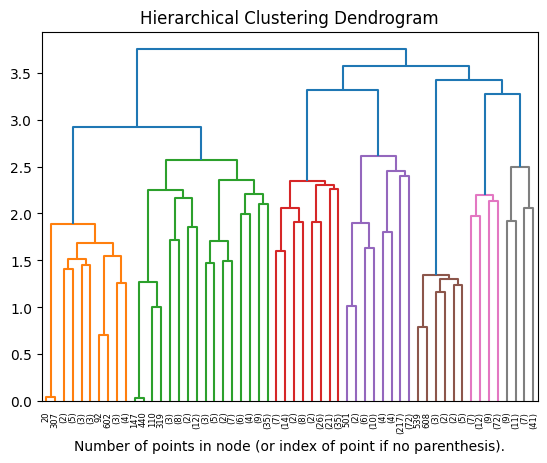

In [21]:
# setting distance_threshold=0 ensures we compute the full tree.
cls2 = AgglomerativeClustering(n_clusters=None, metric='euclidean', linkage='ward', distance_threshold=0)
cls2 = cls2.fit(tfidf_matrix.toarray())

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(cls2, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

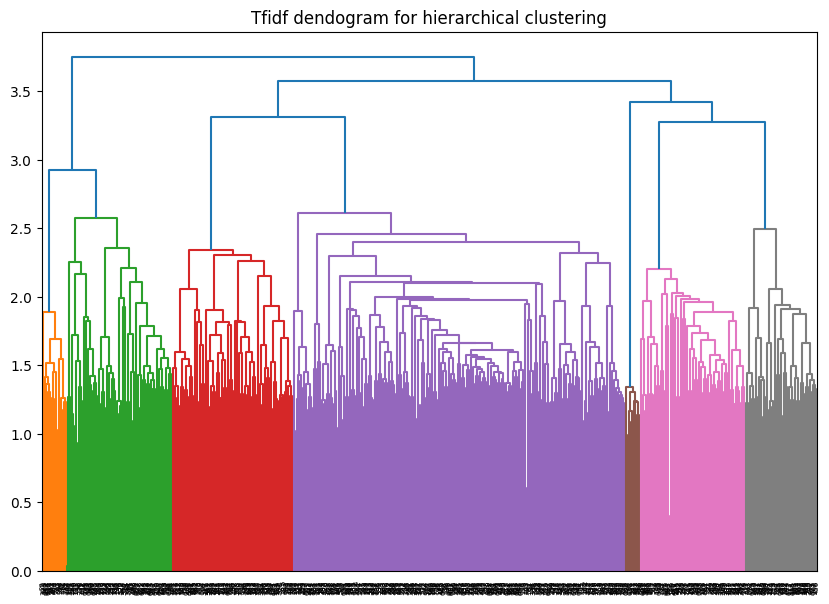

In [22]:
# here is another way of plotting the hc using the scipy library
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Tfidf dendogram for hierarchical clustering")
dend = shc.dendrogram(shc.linkage(tfidf_matrix.toarray(), method='ward'))

### Topic modeling

Topic modeling is another unsupervised method for text mining applications where we want to get an idea of what topics we have in our dataset. A topic is a collection of words that describe the overall theme. For example, in case of news articles, you might think of topics as the categories in the dataset. Just like clustering algorithms, there are some algorithms that need you to specify the number of topics you want to extract from the dataset and some that automatically determine the number of topics. Here, we are going to use the Latent Dirichlet Allocation (LDA) method for topic modeling. You can check sklearn's documentation for more details about LDA from the `sklearn.decomposition` module.

12\. **One of the mainly used approaches for topic modeling is Latent Dirichlet Allocation (LDA). The LDA is based upon two general assumptions:**

- Documents exhibit multiple topics
- A topic is a distribution over a fixed vocabulary

**Train a LDA model from the `sklearn` package for topic modeling with 5 components.****

In [23]:
LDA = LatentDirichletAllocation(n_components=5, random_state=321, evaluate_every=10)
LDA.fit(tfidf_matrix)

LatentDirichletAllocation(evaluate_every=10, n_components=5, random_state=321)

We used LDA to create topics along with the probability distribution for each word in our vocabulary for each topic. The parameter `n_components` specifies the number of categories, or topics, that we want our text to be divided into.

13\. **Print the 10 words with highest probabilities for all the five topics.**

In [24]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['play', 'cup', 'players', 'team', 'win', 'world', 'year', 'game', 'england', 'said']


Top 10 words for topic #1:
['maurice', 'holmes', 'capriati', 'mauresmo', 'isinbayeva', 'sharapova', 'greene', 'lewis francis', 'francis', 'mirza']


Top 10 words for topic #2:
['gregory lamboley', 'imanol', 'half replacement', 'valbon', 'harinordoquy', 'stade', 'bortolami', 'bourgoin', 'toulousain', 'stade toulousain']


Top 10 words for topic #3:
['tribunal', 'charges', 'balco', 'conte', 'drugs', 'doping', 'thanou', 'greek', 'iaaf', 'kenteris']


Top 10 words for topic #4:
['money women', 'rod', 'aus', 'ind', 'pattaya', 'prize money', 'kafer', 'martinez', 'umaga', 'hingis']




You can also use the following function for this purpose:

In [25]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [26]:
no_top_words = 10
display_topics(LDA, tfidf_vectorizer.get_feature_names_out(), no_top_words=4)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,said,21.1,mirza,2.2,stade toulousain,1.0,kenteris,3.5,hingis,1.0
1,england,18.2,francis,2.0,toulousain,1.0,iaaf,3.1,umaga,1.0
2,game,13.8,lewis francis,2.0,bourgoin,0.6,greek,3.1,martinez,0.9
3,year,13.6,greene,1.7,bortolami,0.6,thanou,3.1,kafer,0.8


14\. **Transform the learned topics into your data. Check the shape of the output. What can be the use of this output?**

In [27]:
topic_values = LDA.transform(tfidf_matrix)
topic_values.shape

(737, 5)

In [28]:
topic_values

array([[0.95297704, 0.01175449, 0.01175873, 0.01175444, 0.01175529],
       [0.94455696, 0.01385469, 0.01387983, 0.0138542 , 0.01385432],
       [0.94949035, 0.01264149, 0.01261802, 0.01263226, 0.01261788],
       ...,
       [0.92571628, 0.01857336, 0.01856985, 0.01857083, 0.01856967],
       [0.4823713 , 0.48677254, 0.01028672, 0.01028405, 0.0102854 ],
       [0.363303  , 0.01191515, 0.60094594, 0.01191983, 0.01191608]])

This output can be used as our new observations and features for further tasks.

15\. **Use the `score` function for LDA to calculate the log likelihood for your data. Compare two LDA models with 5 and 10 topics.**

In [29]:
LDA10 = LatentDirichletAllocation(n_components=10, random_state=321, evaluate_every=10)
LDA10.fit(tfidf_matrix)
print("The log likelihood for the LDA model with 5 topics:", LDA.score(tfidf_matrix))
print("The log likelihood for the LDA model with 10 topics:", LDA10.score(tfidf_matrix))

The log likelihood for the LDA model with 5 topics: -91498.09007139162
The log likelihood for the LDA model with 10 topics: -106388.86181536067


Many procedures use the log of the likelihood, rather than the likelihood itself, because it is easier to work with. The log likelihood (i.e., the log of the likelihood) will always be negative, with higher values (closer to zero) indicating a better fitting model. Here this belongs to the model with 5 topics.